In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy import stats
from scipy.stats import poisson
from scipy.stats import norm

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [5]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [4]:
hf.keys()

<KeysViewHDF5 ['data']>

In [5]:
data = np.array(hf.get('data'))

In [6]:
hf.close()

Problem 1

The goal is to understand our data and eventually be able to build a background pdf(). Let's explore this data with some plots

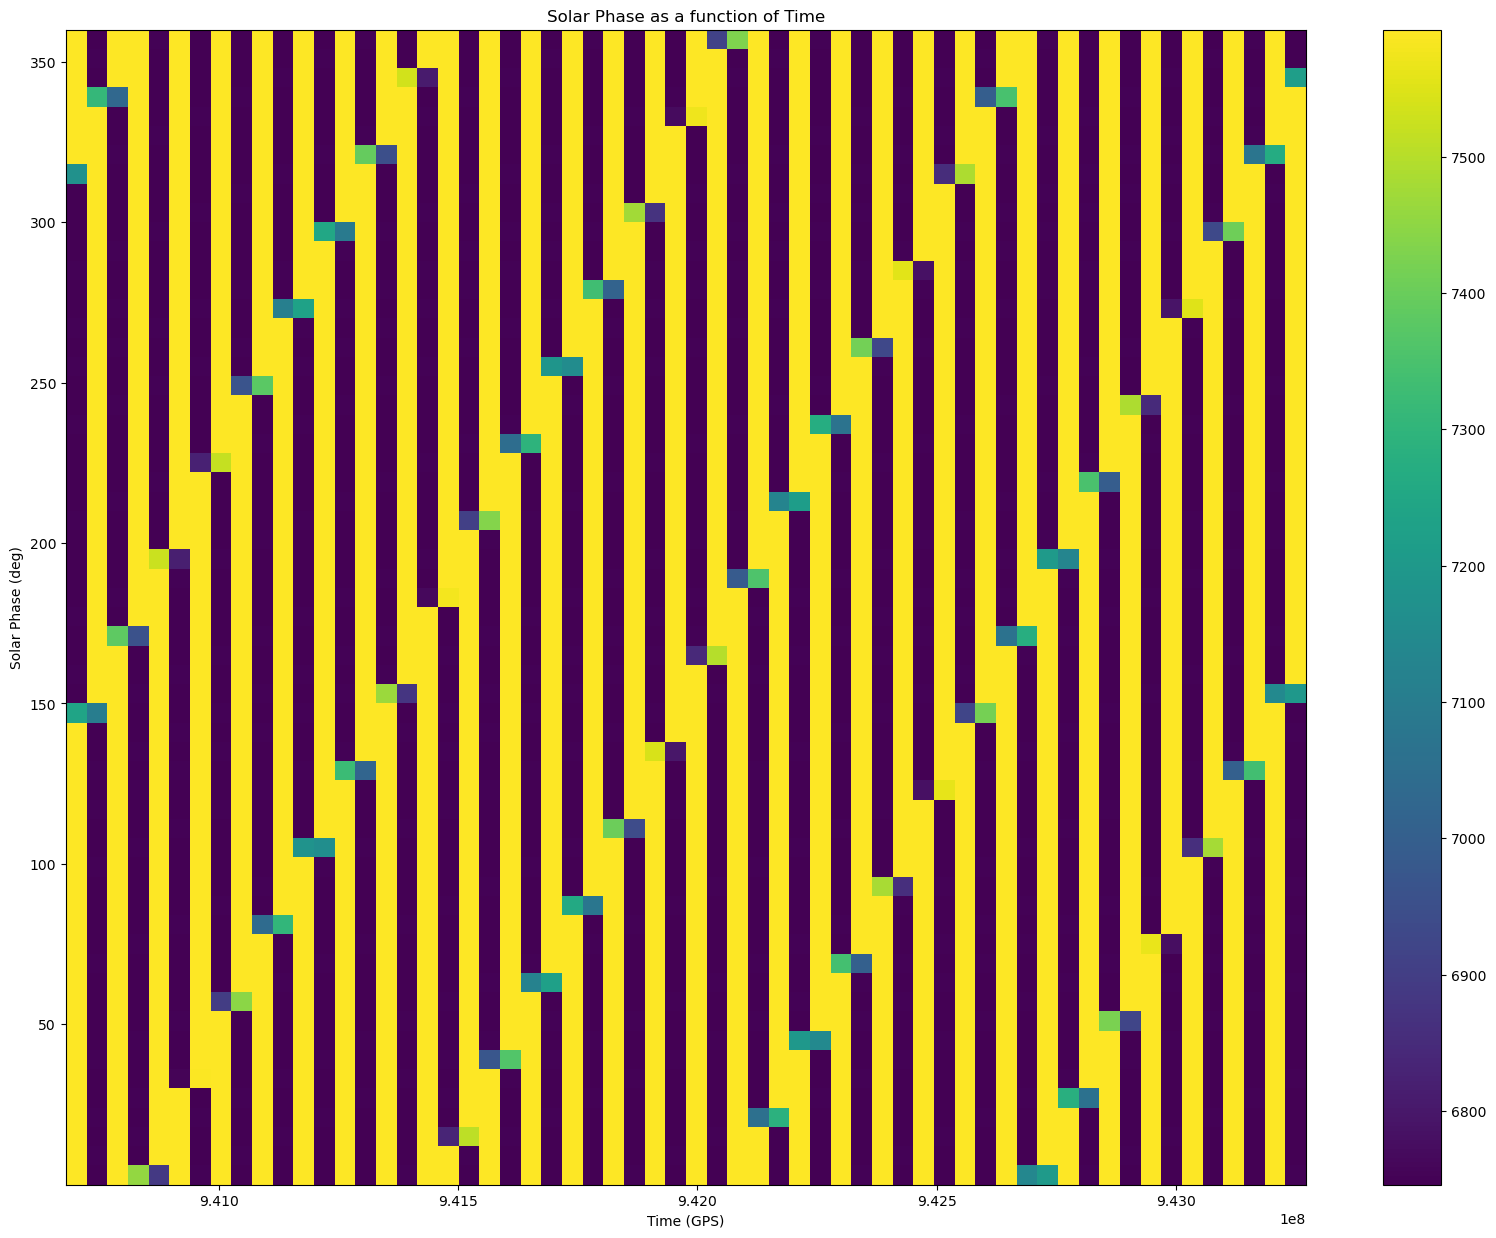

In [39]:
#solar phase vs time
t = data[0]
phase = data[1]
plt.hist2d(t,phase,bins=60)
plt.title('Solar Phase as a function of Time')
plt.xlabel('Time (GPS)')
plt.ylabel('Solar Phase (deg)')
plt.colorbar()
plt.show()

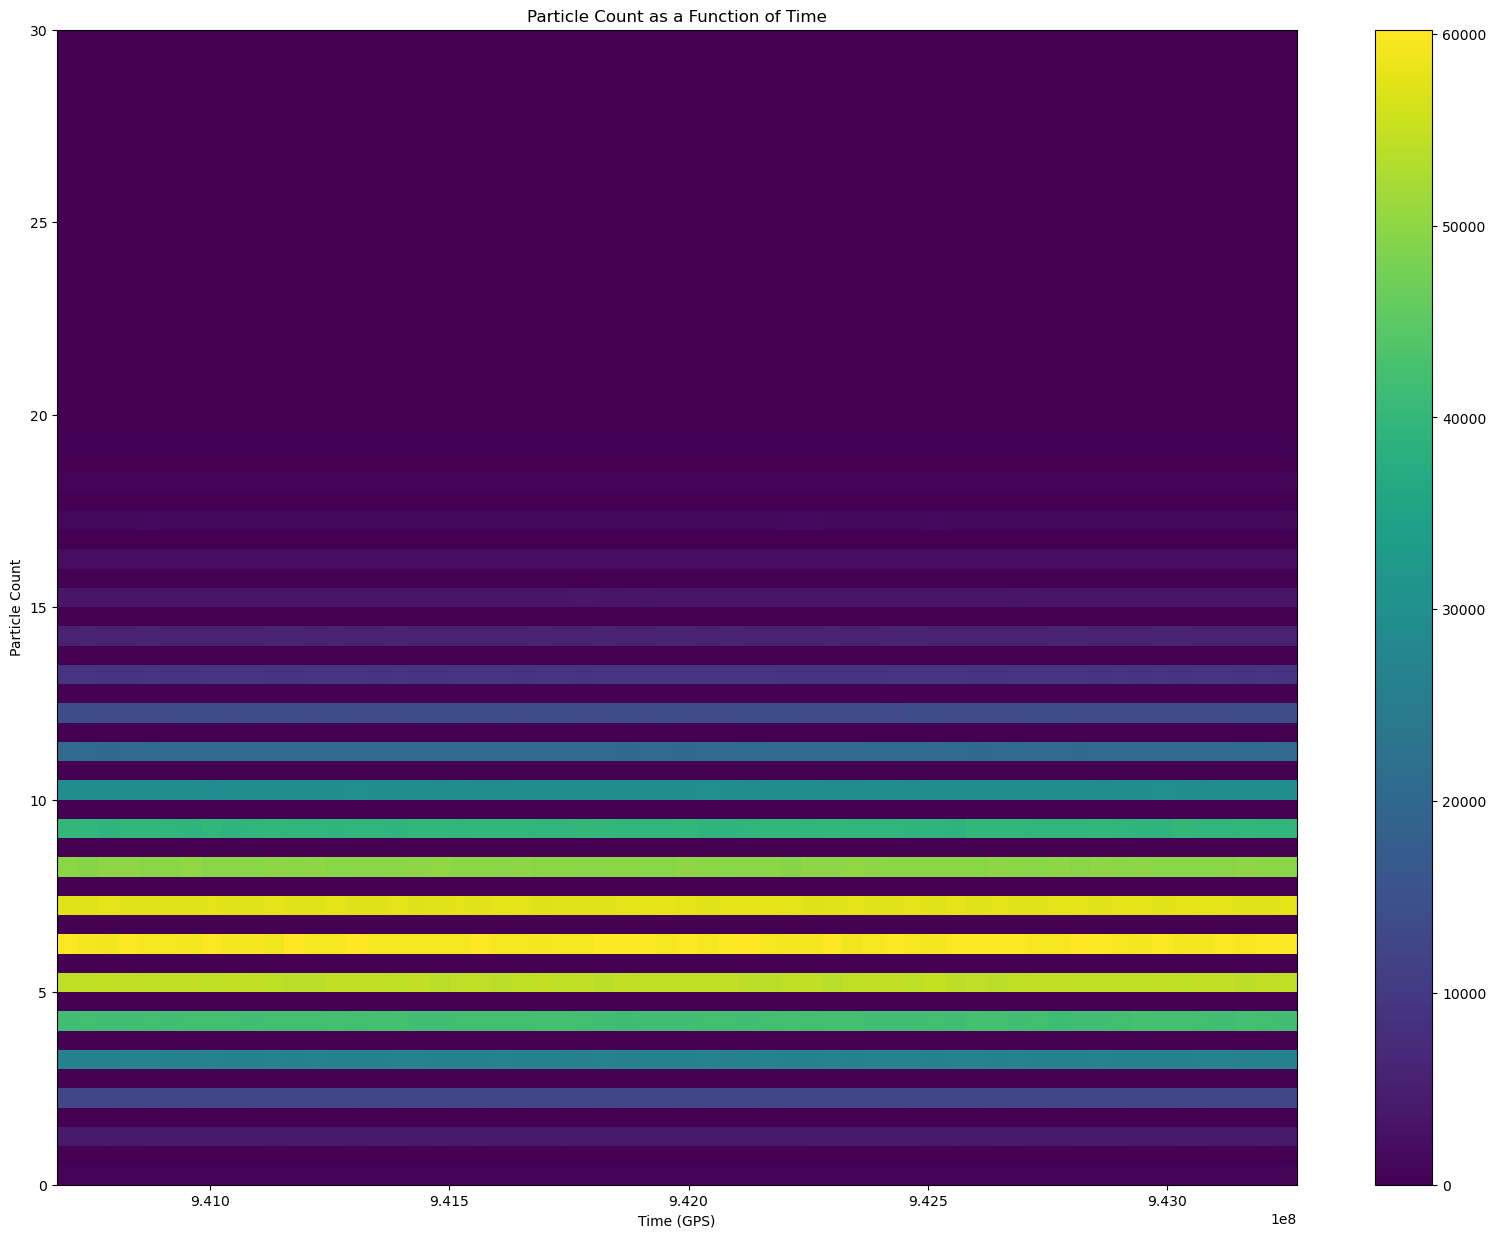

In [38]:
#Particle counts vs time
count = data[3]
plt.hist2d(t,count,bins=60)
plt.title('Particle Count as a Function of Time')
plt.ylabel('Particle Count')
plt.xlabel('Time (GPS)')
plt.colorbar()
plt.show()

The reasoning behind all of these plots, specifically the ones that are as a function of time, is to explore the periodicity of the data. We need to fold the data to explore the periodicity. We know that the satellite completes an orbit every 90 minutes (5400 s). Folding the time, we can see a cyclic pattern:

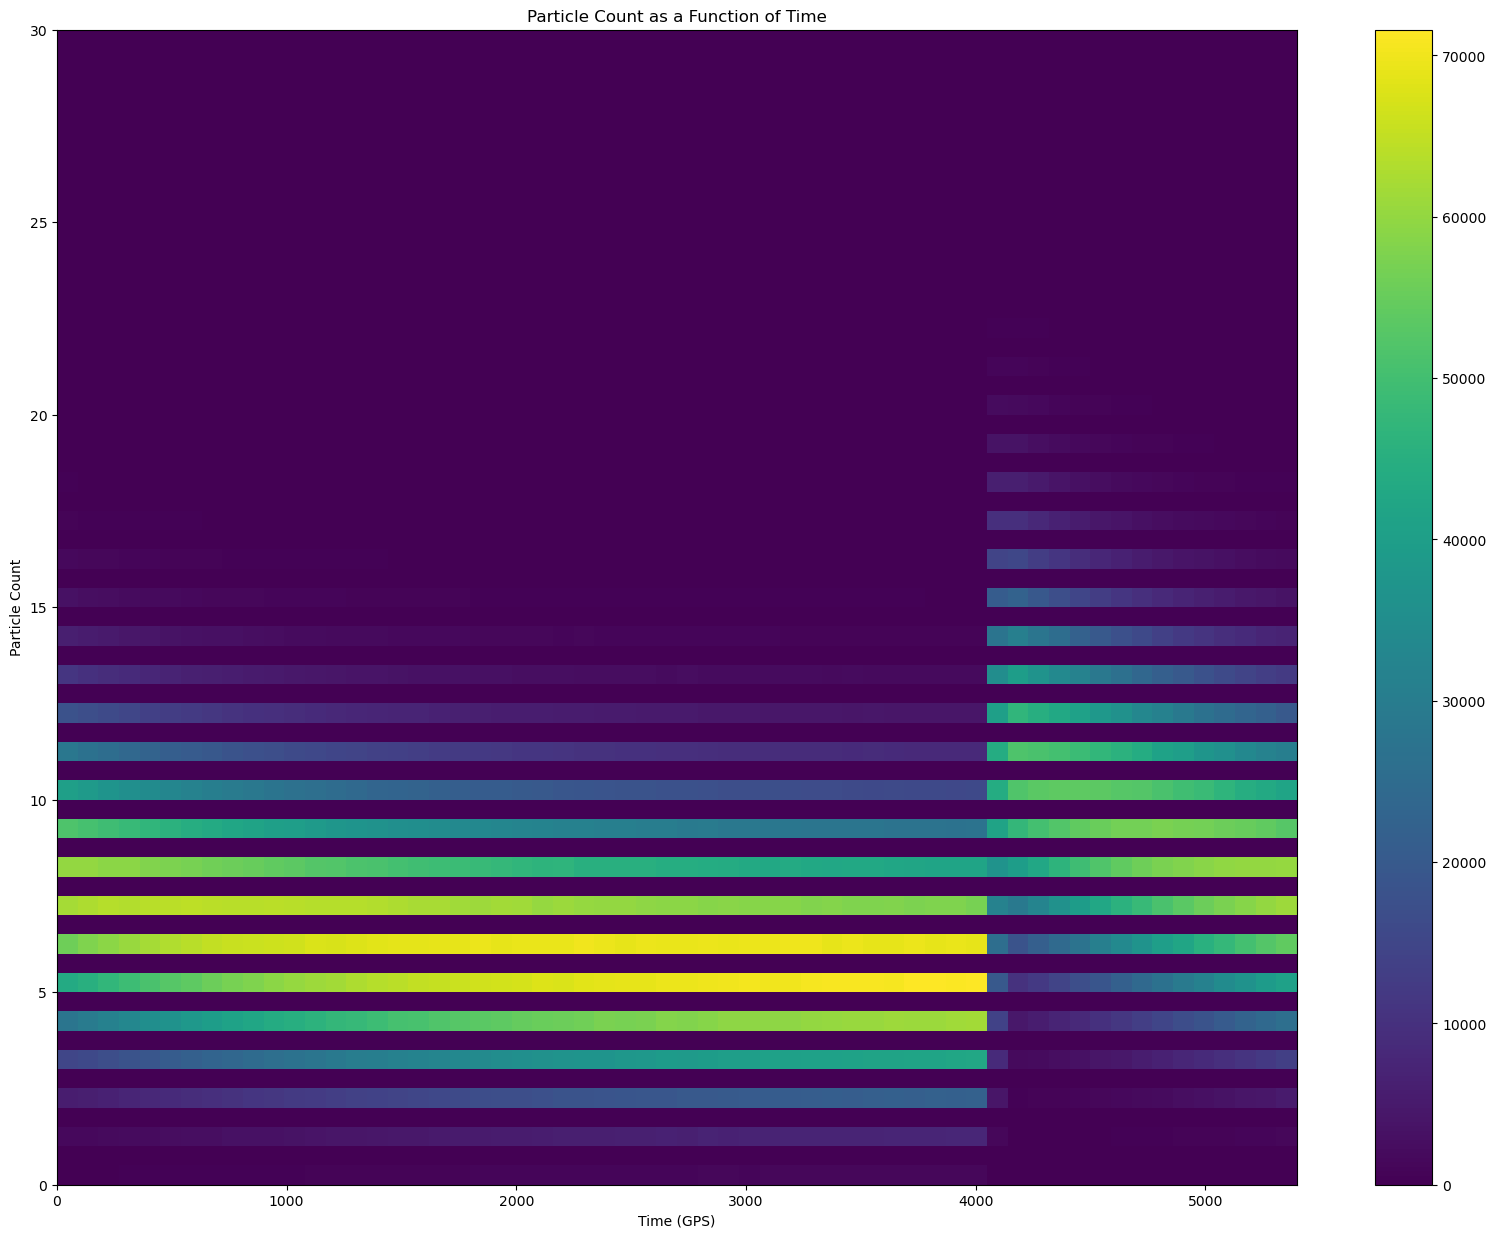

In [37]:
foldedt = np.mod(t,5400)
plt.hist2d(foldedt,count,bins=60)
plt.title('Particle Count as a Function of Time')
plt.ylabel('Particle Count')
plt.xlabel('Time (GPS)')
plt.colorbar()
plt.show()

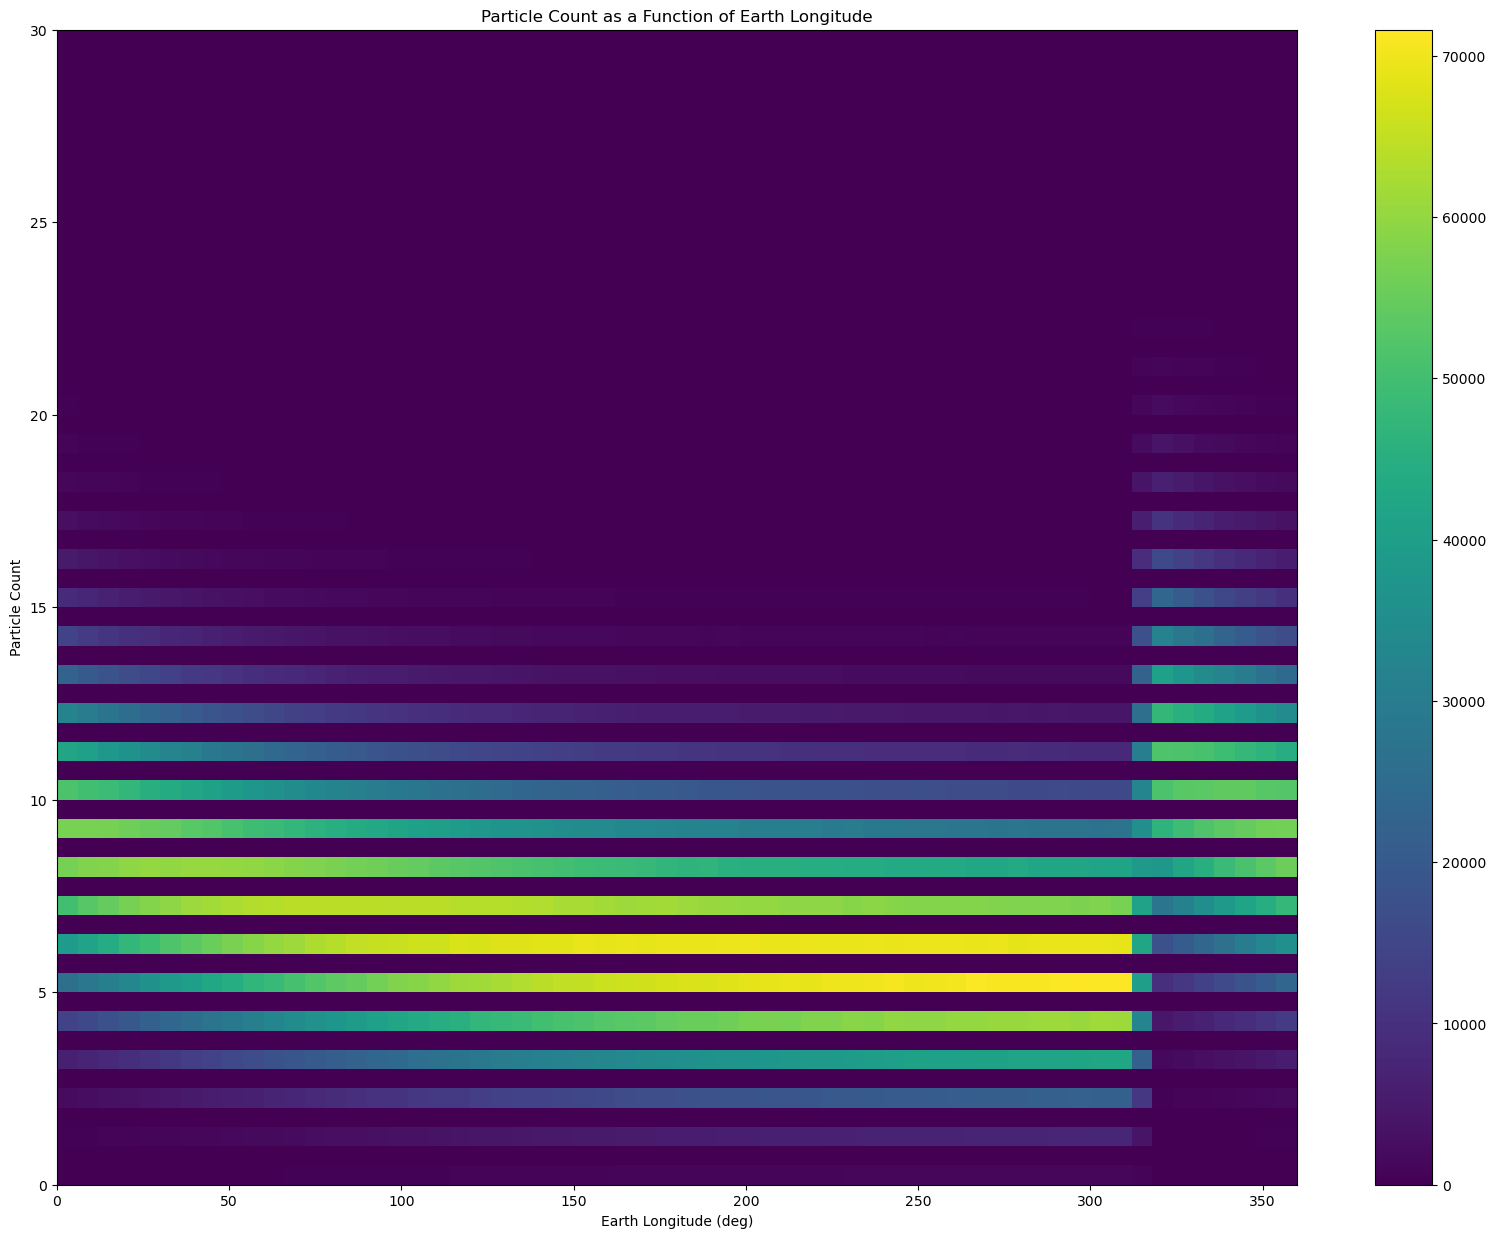

In [13]:
#Particle Count vs earth longitude
longitude = data[2]
plt.hist2d(longitude,count,bins=60)
plt.title('Particle Count as a Function of Earth Longitude')
plt.ylabel('Particle Count')
plt.xlabel('Earth Longitude (deg)')
plt.colorbar()
plt.show()

As we can see from the plot above, the data set spikes at around 325 degrees. Let's explore this a little further.

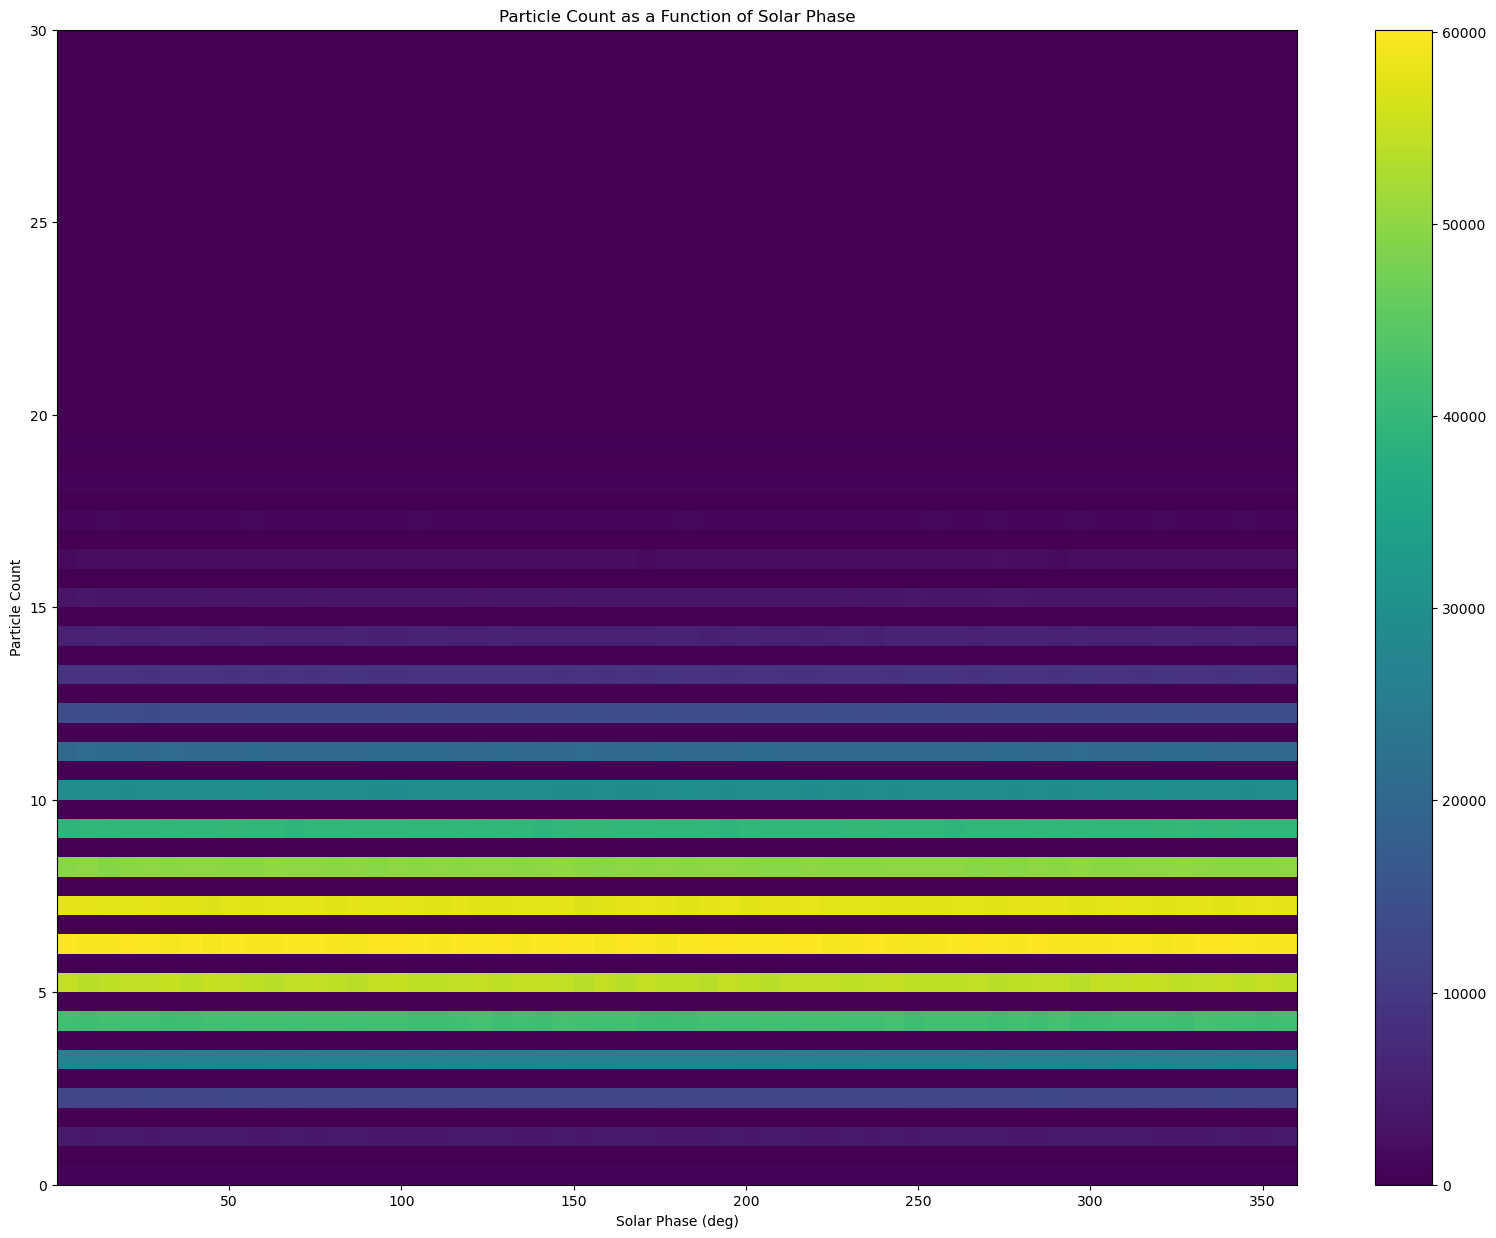

In [14]:
#Particle Count vs solar phase
plt.hist2d(phase,count,bins=60)
plt.title('Particle Count as a Function of Solar Phase')
plt.ylabel('Particle Count')
plt.xlabel('Solar Phase (deg)')
plt.colorbar()
plt.show()

This is reminiscent of the poisson distribution which makes sense because the background data is cosmic rays which is a set of discrete data. Let's find out

Text(0, 0.5, 'Probability (log)')

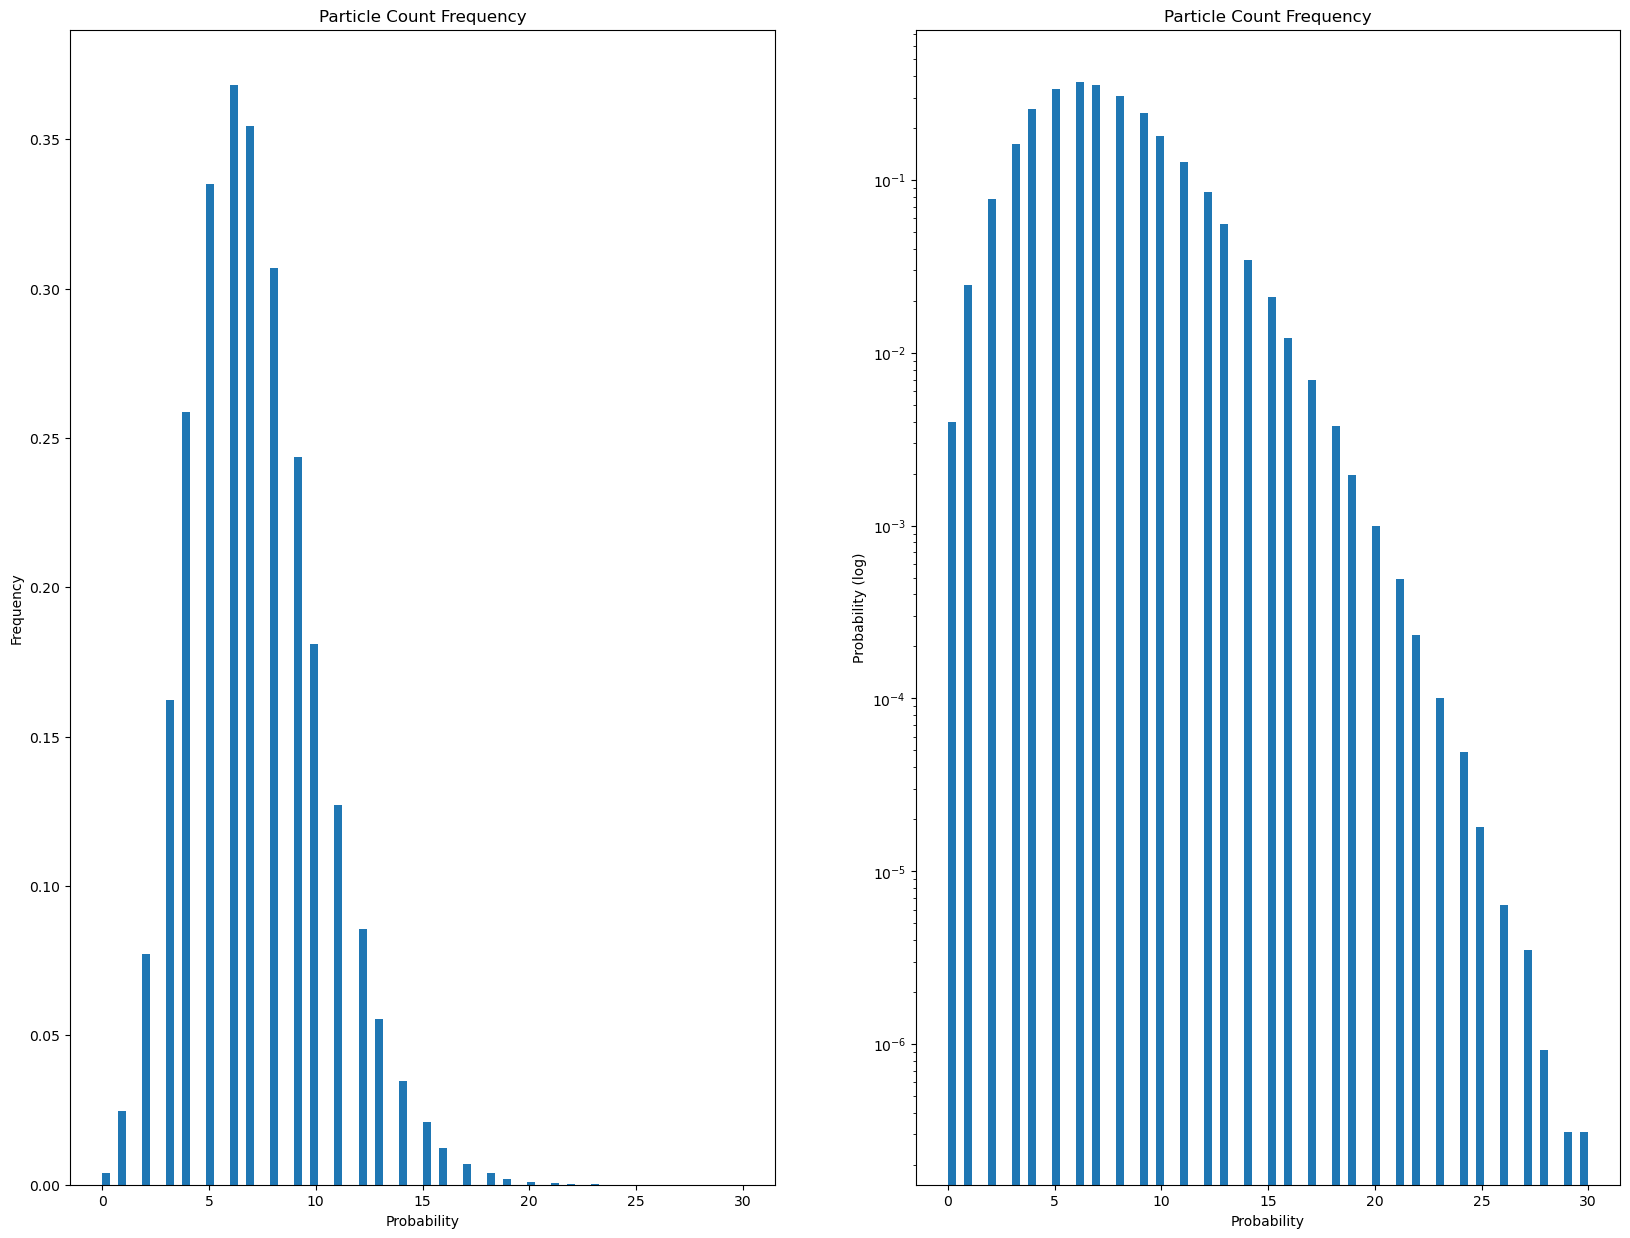

In [15]:
fig,ax = plt.subplots(1,2)
ax[0].hist(count,bins=80,density=True)
ax[0].set_title('Particle Count Frequency')
ax[0].set_xlabel('Probability')
ax[0].set_ylabel('Frequency')

ax[1].hist(count,bins=80,density=True)
plt.yscale('log')
ax[1].set_title('Particle Count Frequency')
ax[1].set_xlabel('Probability')
ax[1].set_ylabel('Probability (log)')

1. By exploring the 2D histograms of several parameters in the data, we are able to build the background distribution which we determined was a poisson distribution. 

2. The background data cannot be consistent over time because there is a periodicity as determined before. Let's look into this further:

Text(0, 0.5, 'Particle Count')

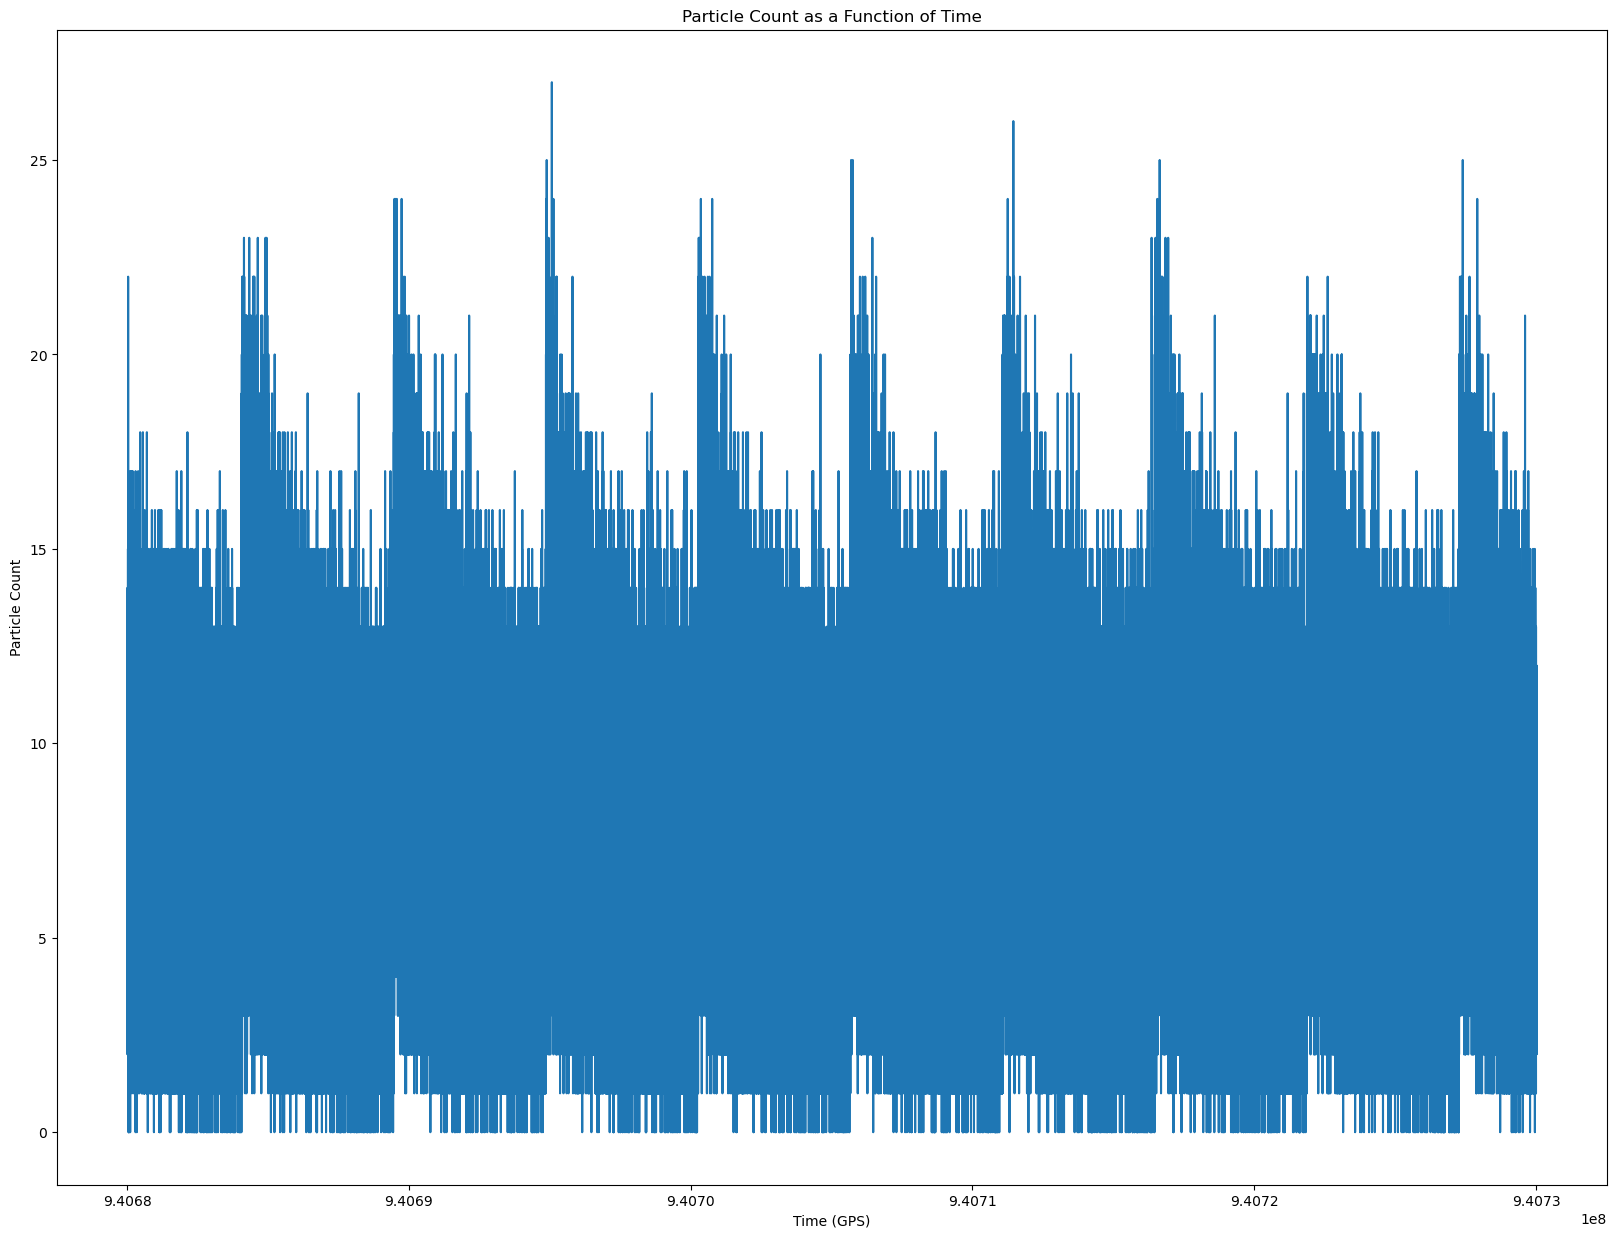

In [16]:
fig,ax = plt.subplots(1,1)
t = data[0,0:500000]
count = data[3,0:500000]
ax.plot(t,count)
ax.set_title("Particle Count as a Function of Time")
ax.set_xlabel('Time (GPS)')
ax.set_ylabel('Particle Count')

Let's find the period by analyzing the difference in time between two peaks: 9.40695 - 9.40690 = 0.00005. This is equivalent to 90 minutes it takes the satelite to complete an orbit. 

3. We can find a model to this background data by finding a distribution to fit the background. This model will also depend on time. We can use the binned_statistics function from scipy library to make a plot of a distribution that shows the mean and distribution around that mean per bin, on top of a regular histogram and the pdf
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html

Text(0, 0.5, 'Average Particle Count')

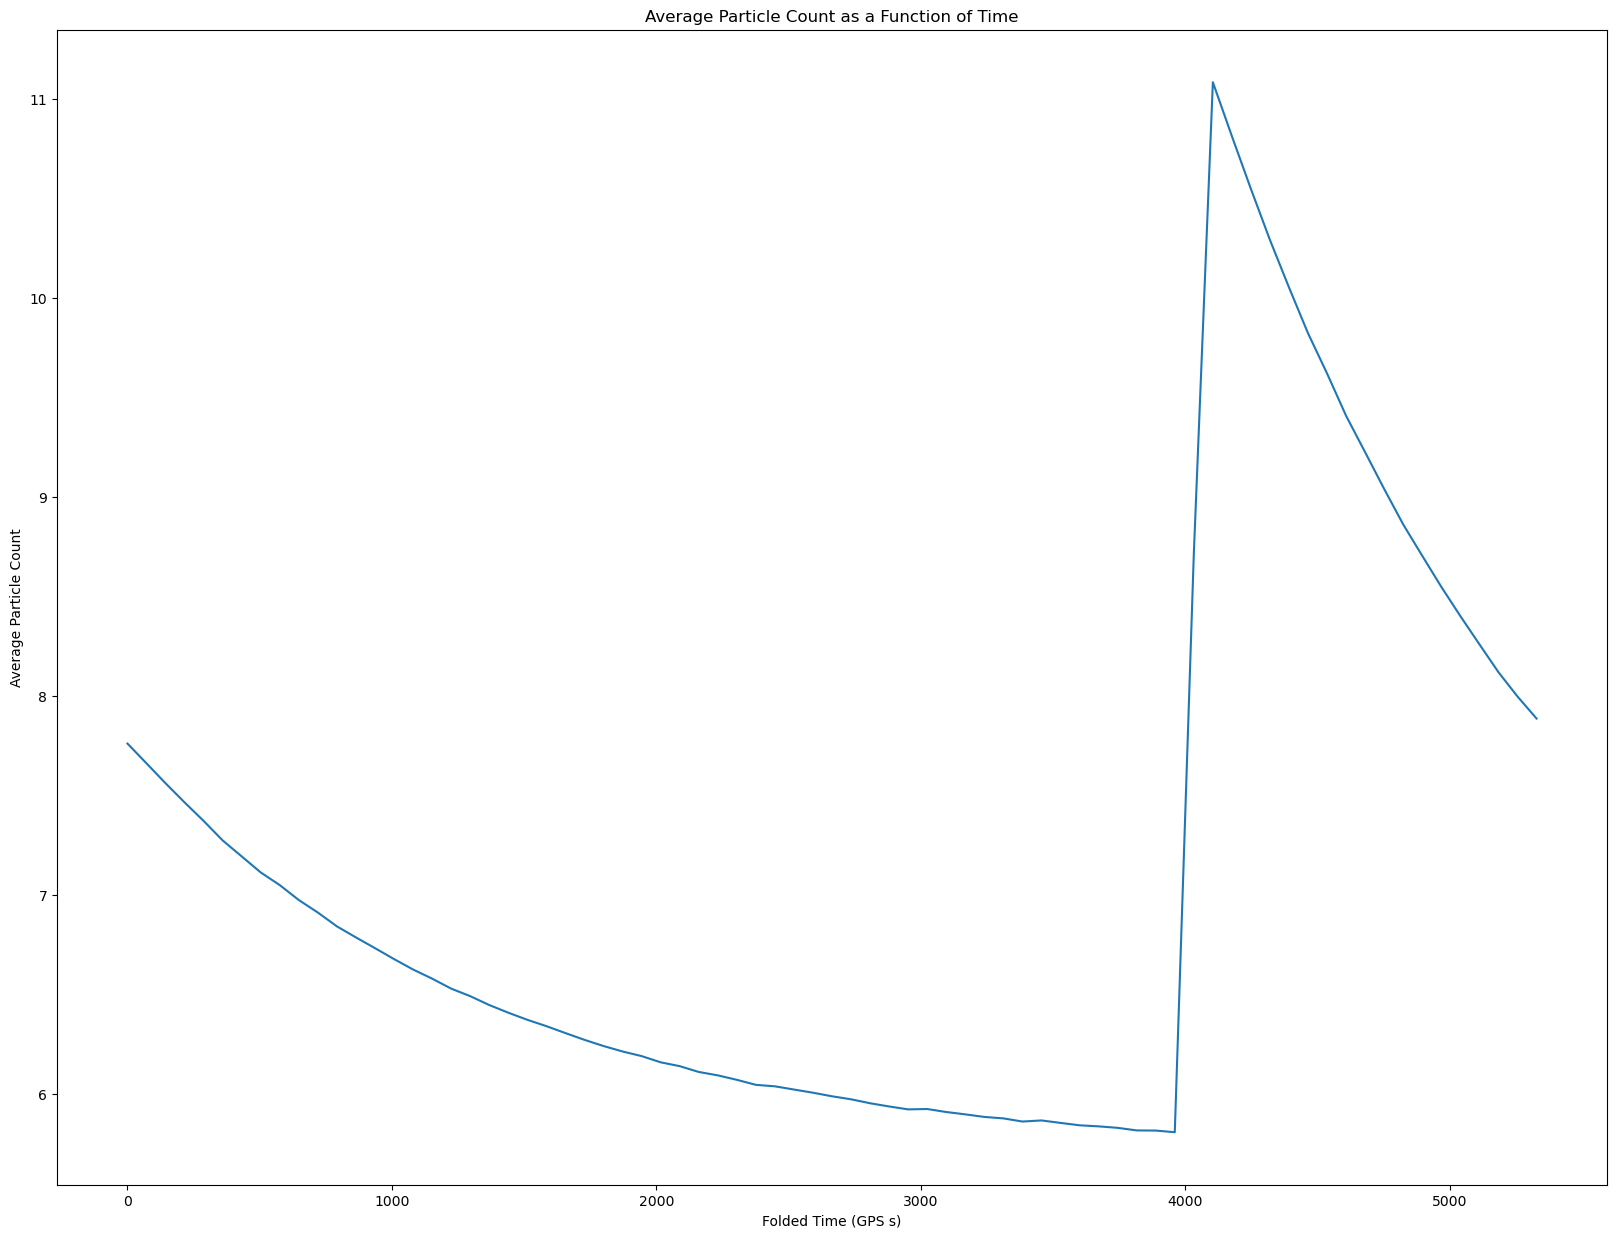

In [24]:
t = data[0,:]
count = data[3,:]
foldedt = np.mod(t,5400)
bin_means, bin_edges, binnumber = stats.binned_statistic(foldedt, count,statistic='mean', bins=75)
plt.plot(bin_edges[:-1],bin_means)
plt.title('Average Particle Count as a Function of Time')
plt.xlabel('Folded Time (GPS s)')
plt.ylabel('Average Particle Count')

In [44]:
len(bin_means)

75

This shows the same trend that we saw in the 2D histograms. We can see the same features such as the spike in data at around 4000 s. This will help us create the background pdf that is dependent on time.

In [26]:
t = data[0]
phase = data[1]
longitude = data[2]
count = data[3]

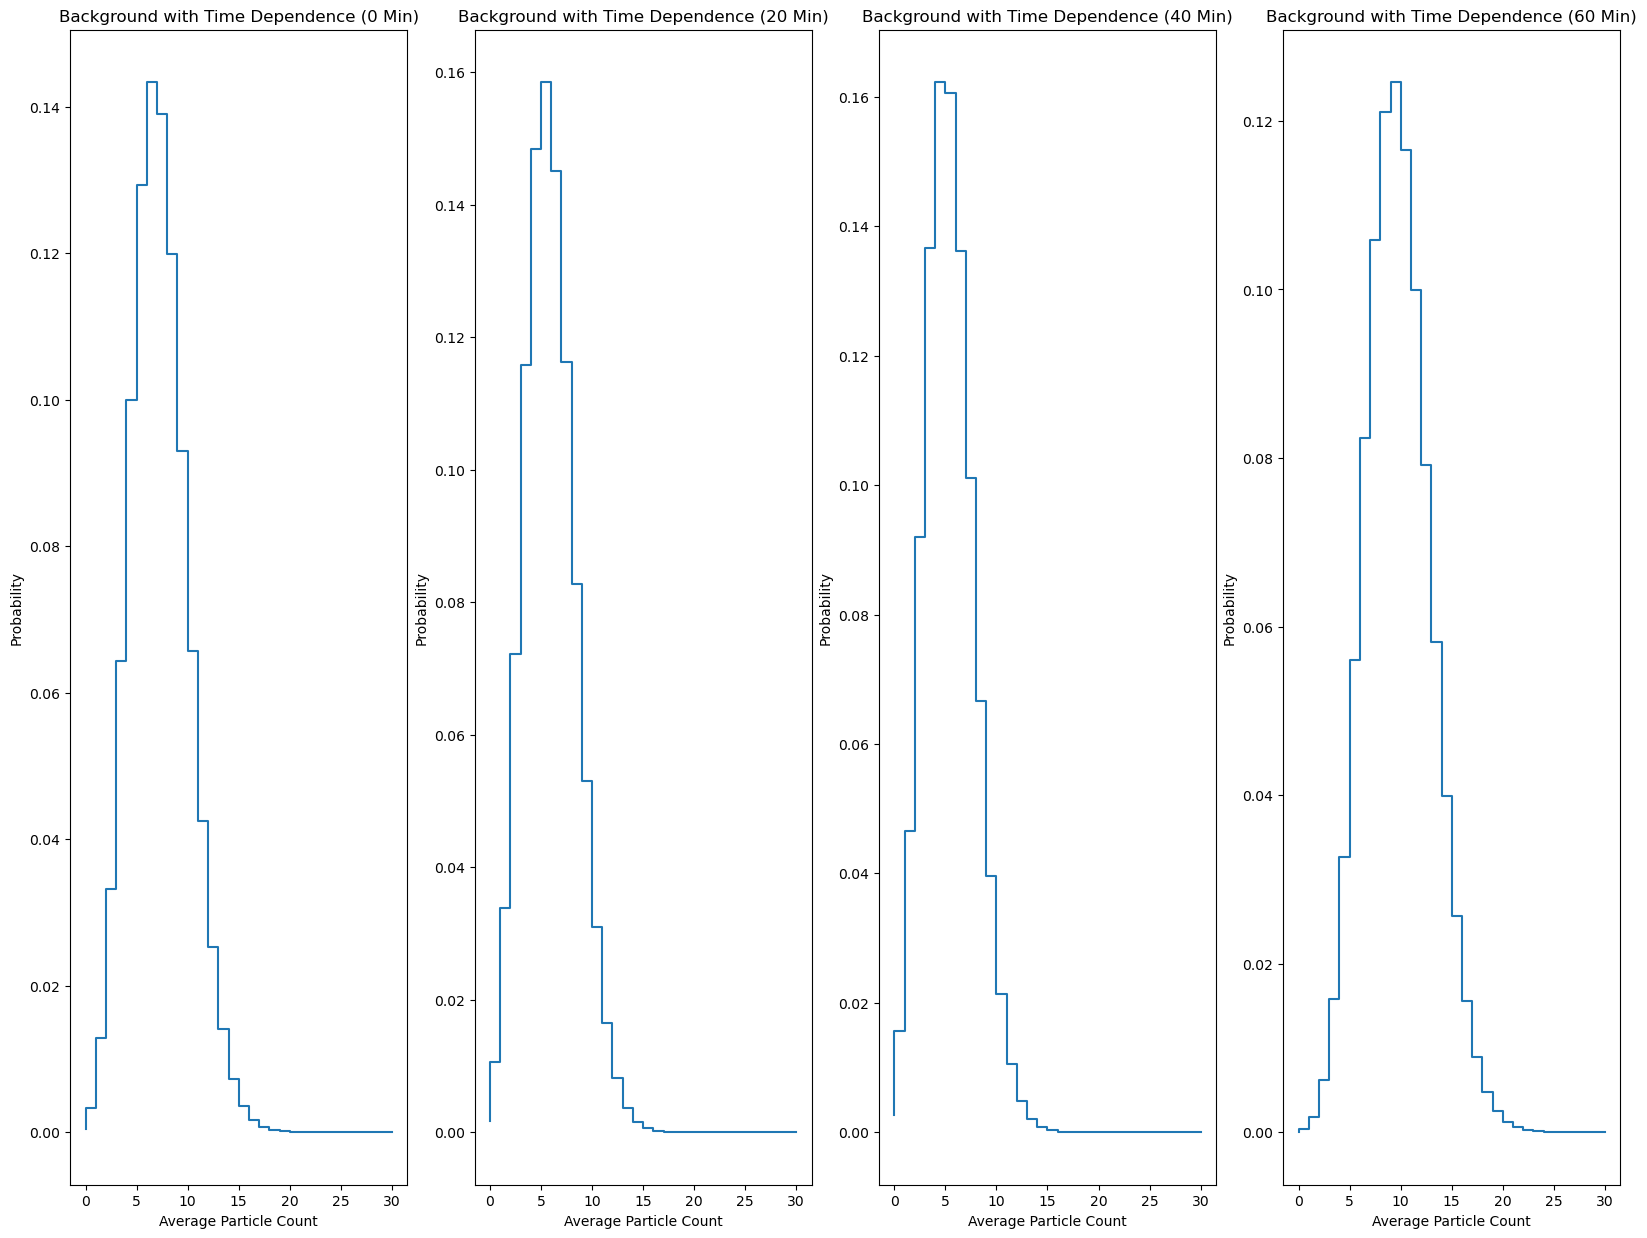

In [32]:
fig,ax = plt.subplots(1,4)
pdf = []
x = np.arange(0,31,1)

for i in range (4):
    pdf.append(poisson.pmf(x,bin_means[i*20]))  #pick times 0, 20, 40, 60
pdf = np.asarray(pdf)
for i in range (4):
    ax[i].step(x,pdf[i])
    ax[i].set_title('Background with Time Dependence (' + str(20*i) + ' Min)')
    ax[i].set_xlabel('Average Particle Count')
    ax[i].set_ylabel('Probability')


We can see that the poisson pdf is dependent on time. By looking at the peak size of each distribution we can see that the form changes slightly as the time goes on. This is a good model of the data because it follows the trend we saw in the 2D histograms. One thing to note is the spike in data we saw in the 2D histograms is not noticeable. Let's see if we can find it. The spike happend at around 4100 s (~68 mins)

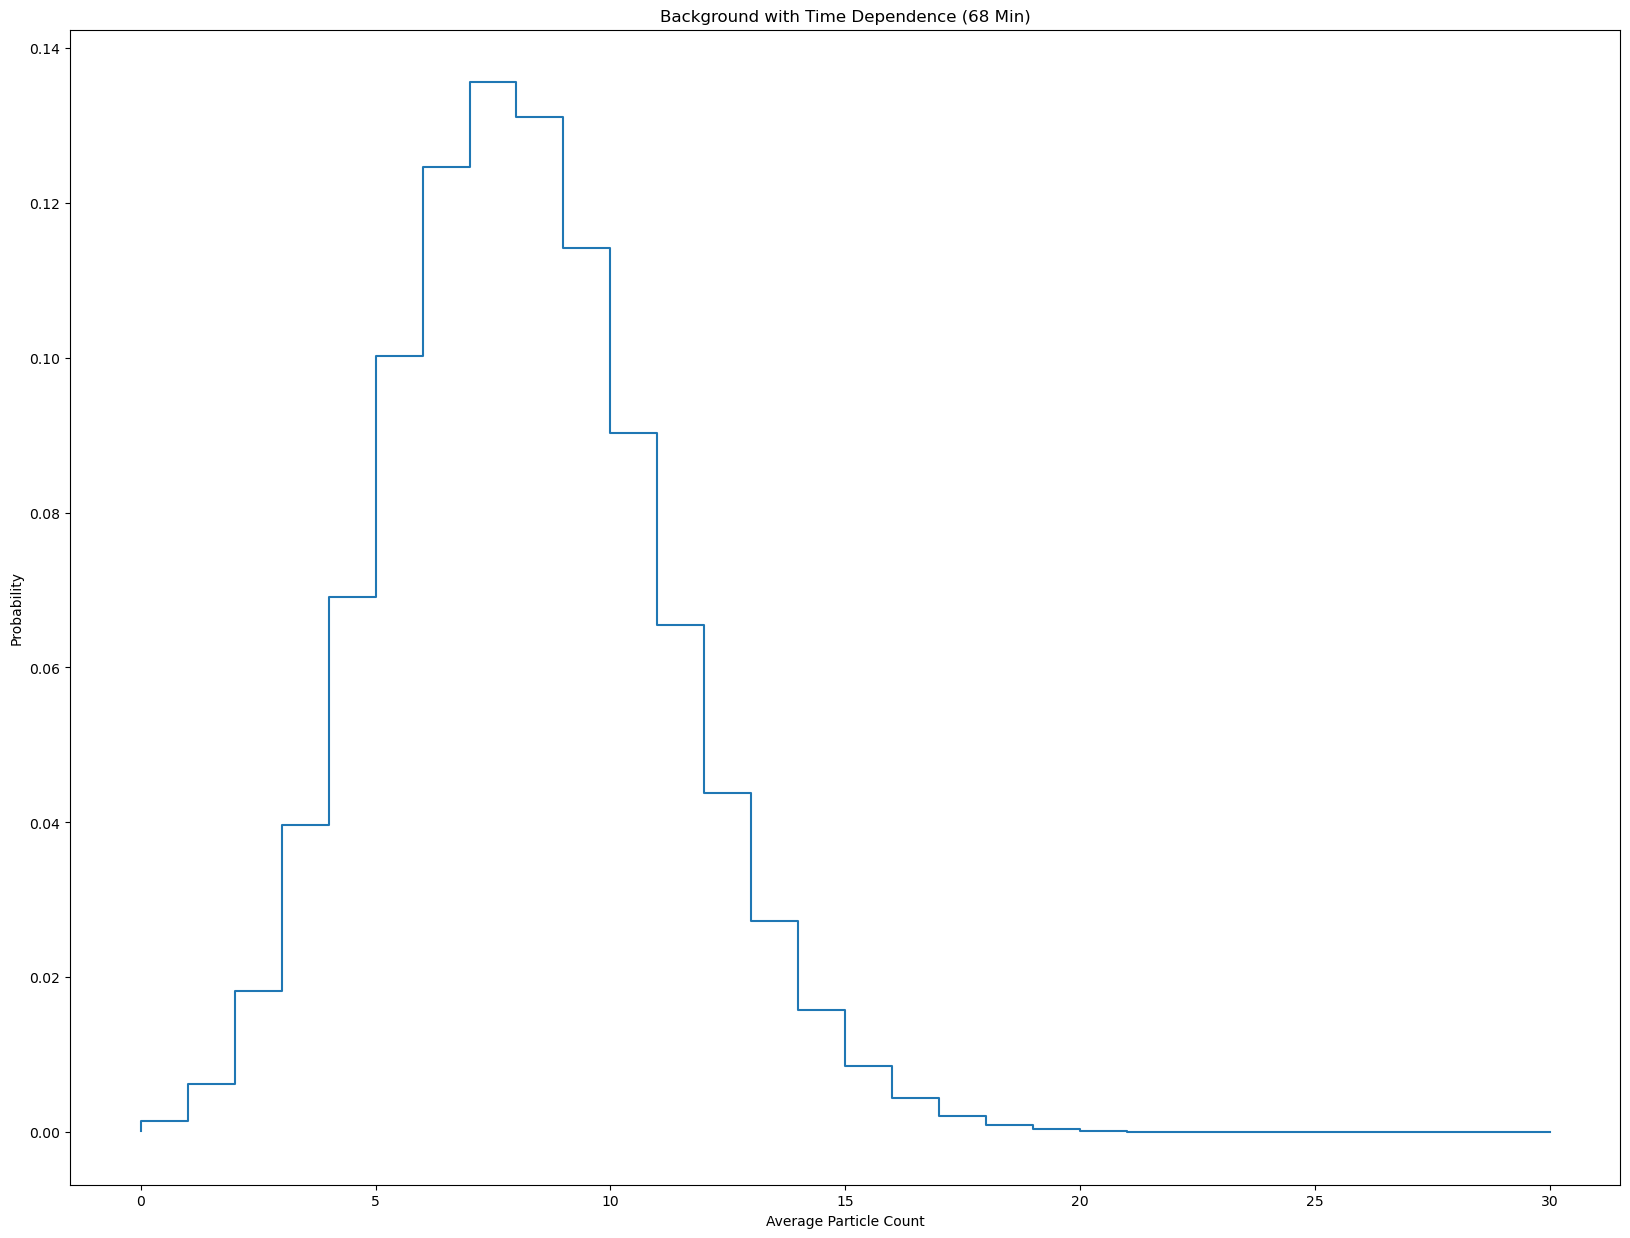

In [34]:
plt.step(x,poisson.pmf(x,bin_means[68]))
plt.title('Background with Time Dependence (' + str(68) + ' Min)')
plt.xlabel('Average Particle Count')
plt.ylabel('Probability')
plt.show()

Notice how the peak is a little higher than the last plot at 60 mins. So we can conclude that this model follows the background data well.

let's now explore the 5-sigma threshold for a 100 millisecond GRB at different times. Let's use the same times I used above.

In [36]:
time = [0, 20, 40, 60, 68]
for i in time:
    cdf = norm.cdf(5)
    sigma = poisson.ppf(cdf,bin_means[i])
    print("sigma at " +str(i) +" mins:"  + str(sigma))

sigma at 0 mins:25.0
sigma at 20 mins:23.0
sigma at 40 mins:22.0
sigma at 60 mins:30.0
sigma at 68 mins:27.0


 Problem 2

In [41]:
image = h5py.File('images.h5', 'r')
imagedata = np.array(image.get('imagestack'))  # pull data out of file
image.close()

Let's explore this data. It is assumed that the images are taken at different points in time at night so if we wanted to check for time dependence we can look for any differences across the images. let's check

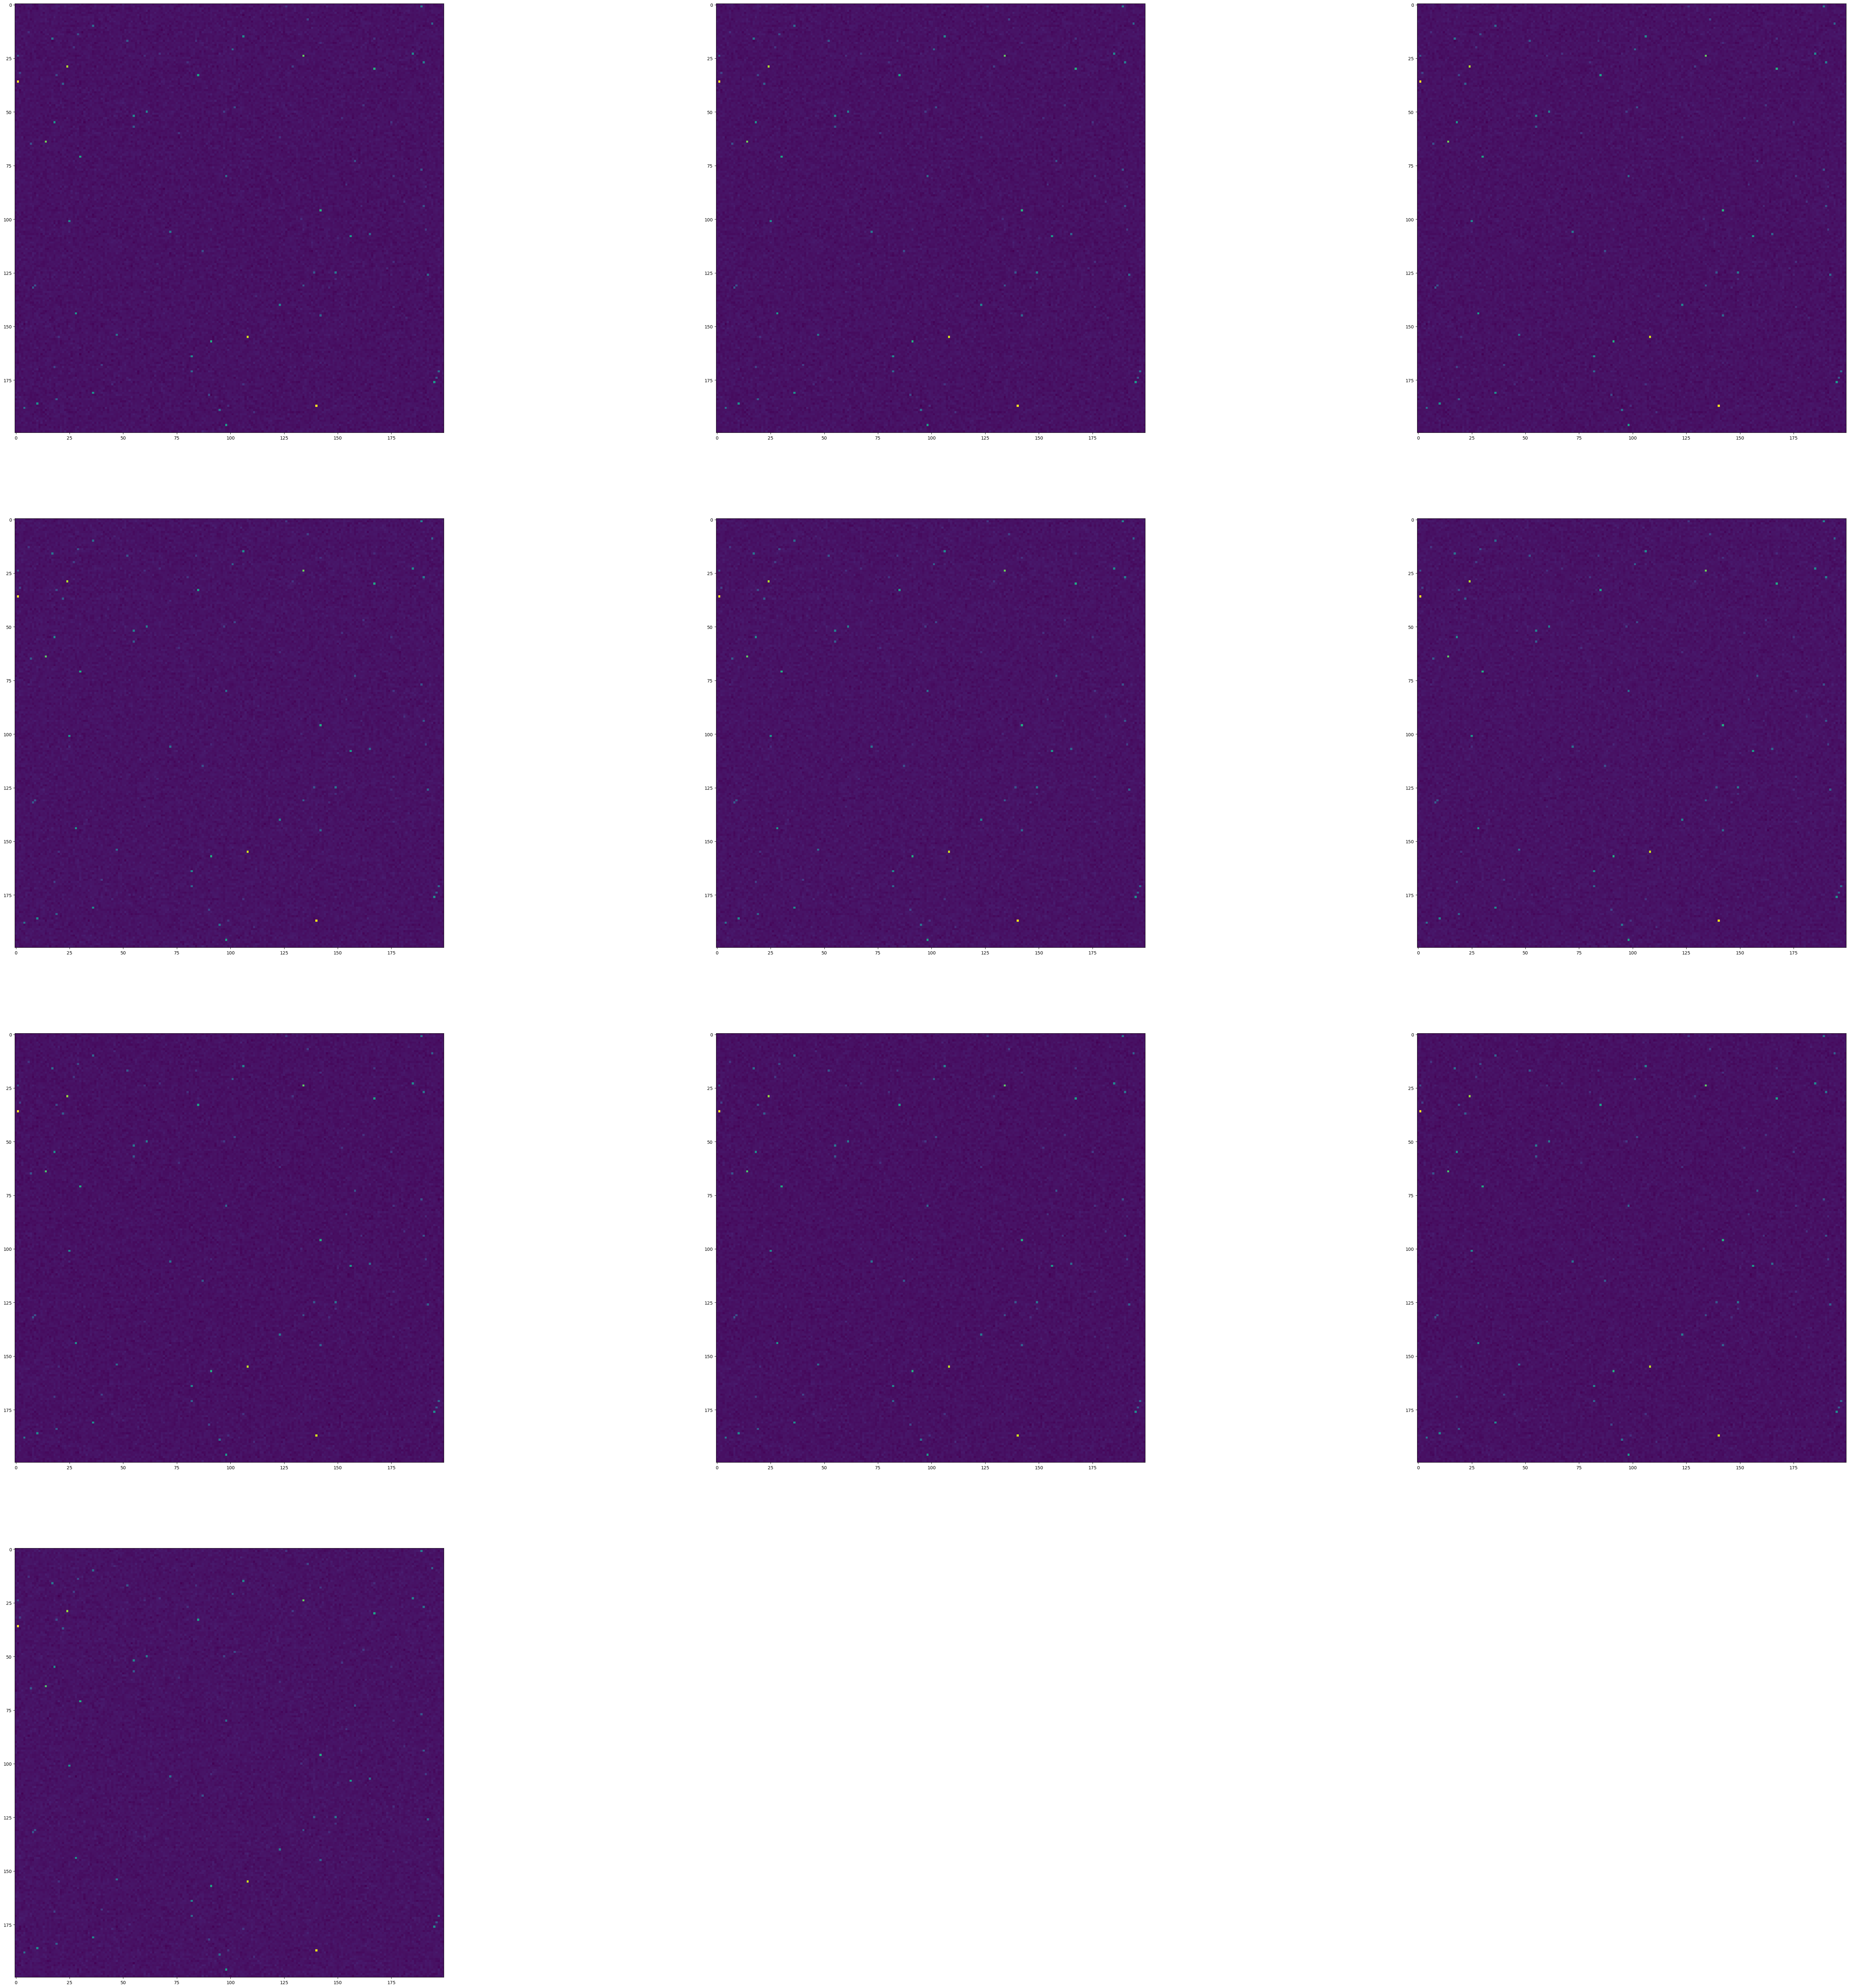

In [42]:
# 10 images 
fig,ax = plt.subplots(4,3,figsize=(80,80))
imageNum = 0
for i in range (3):
    for j in range(3):
        ax[i][j].imshow(imagedata[:,:,imageNum])
    imageNum = imageNum + 1
ax[3][0].imshow(imagedata[:,:,9])
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])

At first look, it seems that the images do not change very much. Also, these plots also tell us that the background is spatially consistent. It is very hard to analyze all the pixels so we will have to come up with a better way of analyzing the images. Across all of the images, however, there has to be signal contamination. The images all show the night sky with stars at different brightness, so the signal that we are looking for must be a feature that is not shared across all images, i.e. a transient because it only lasts a short period of time. So we can build our pdf by first finding the background distribution and how that depends on time and then we can track down the transient in the images based on the fact that the transient event should be brighter than the background.

Let's find the background distribution first. The images are 200x200 pixels and there are 10 images.

In [43]:
imagedata.shape

(200, 200, 10)

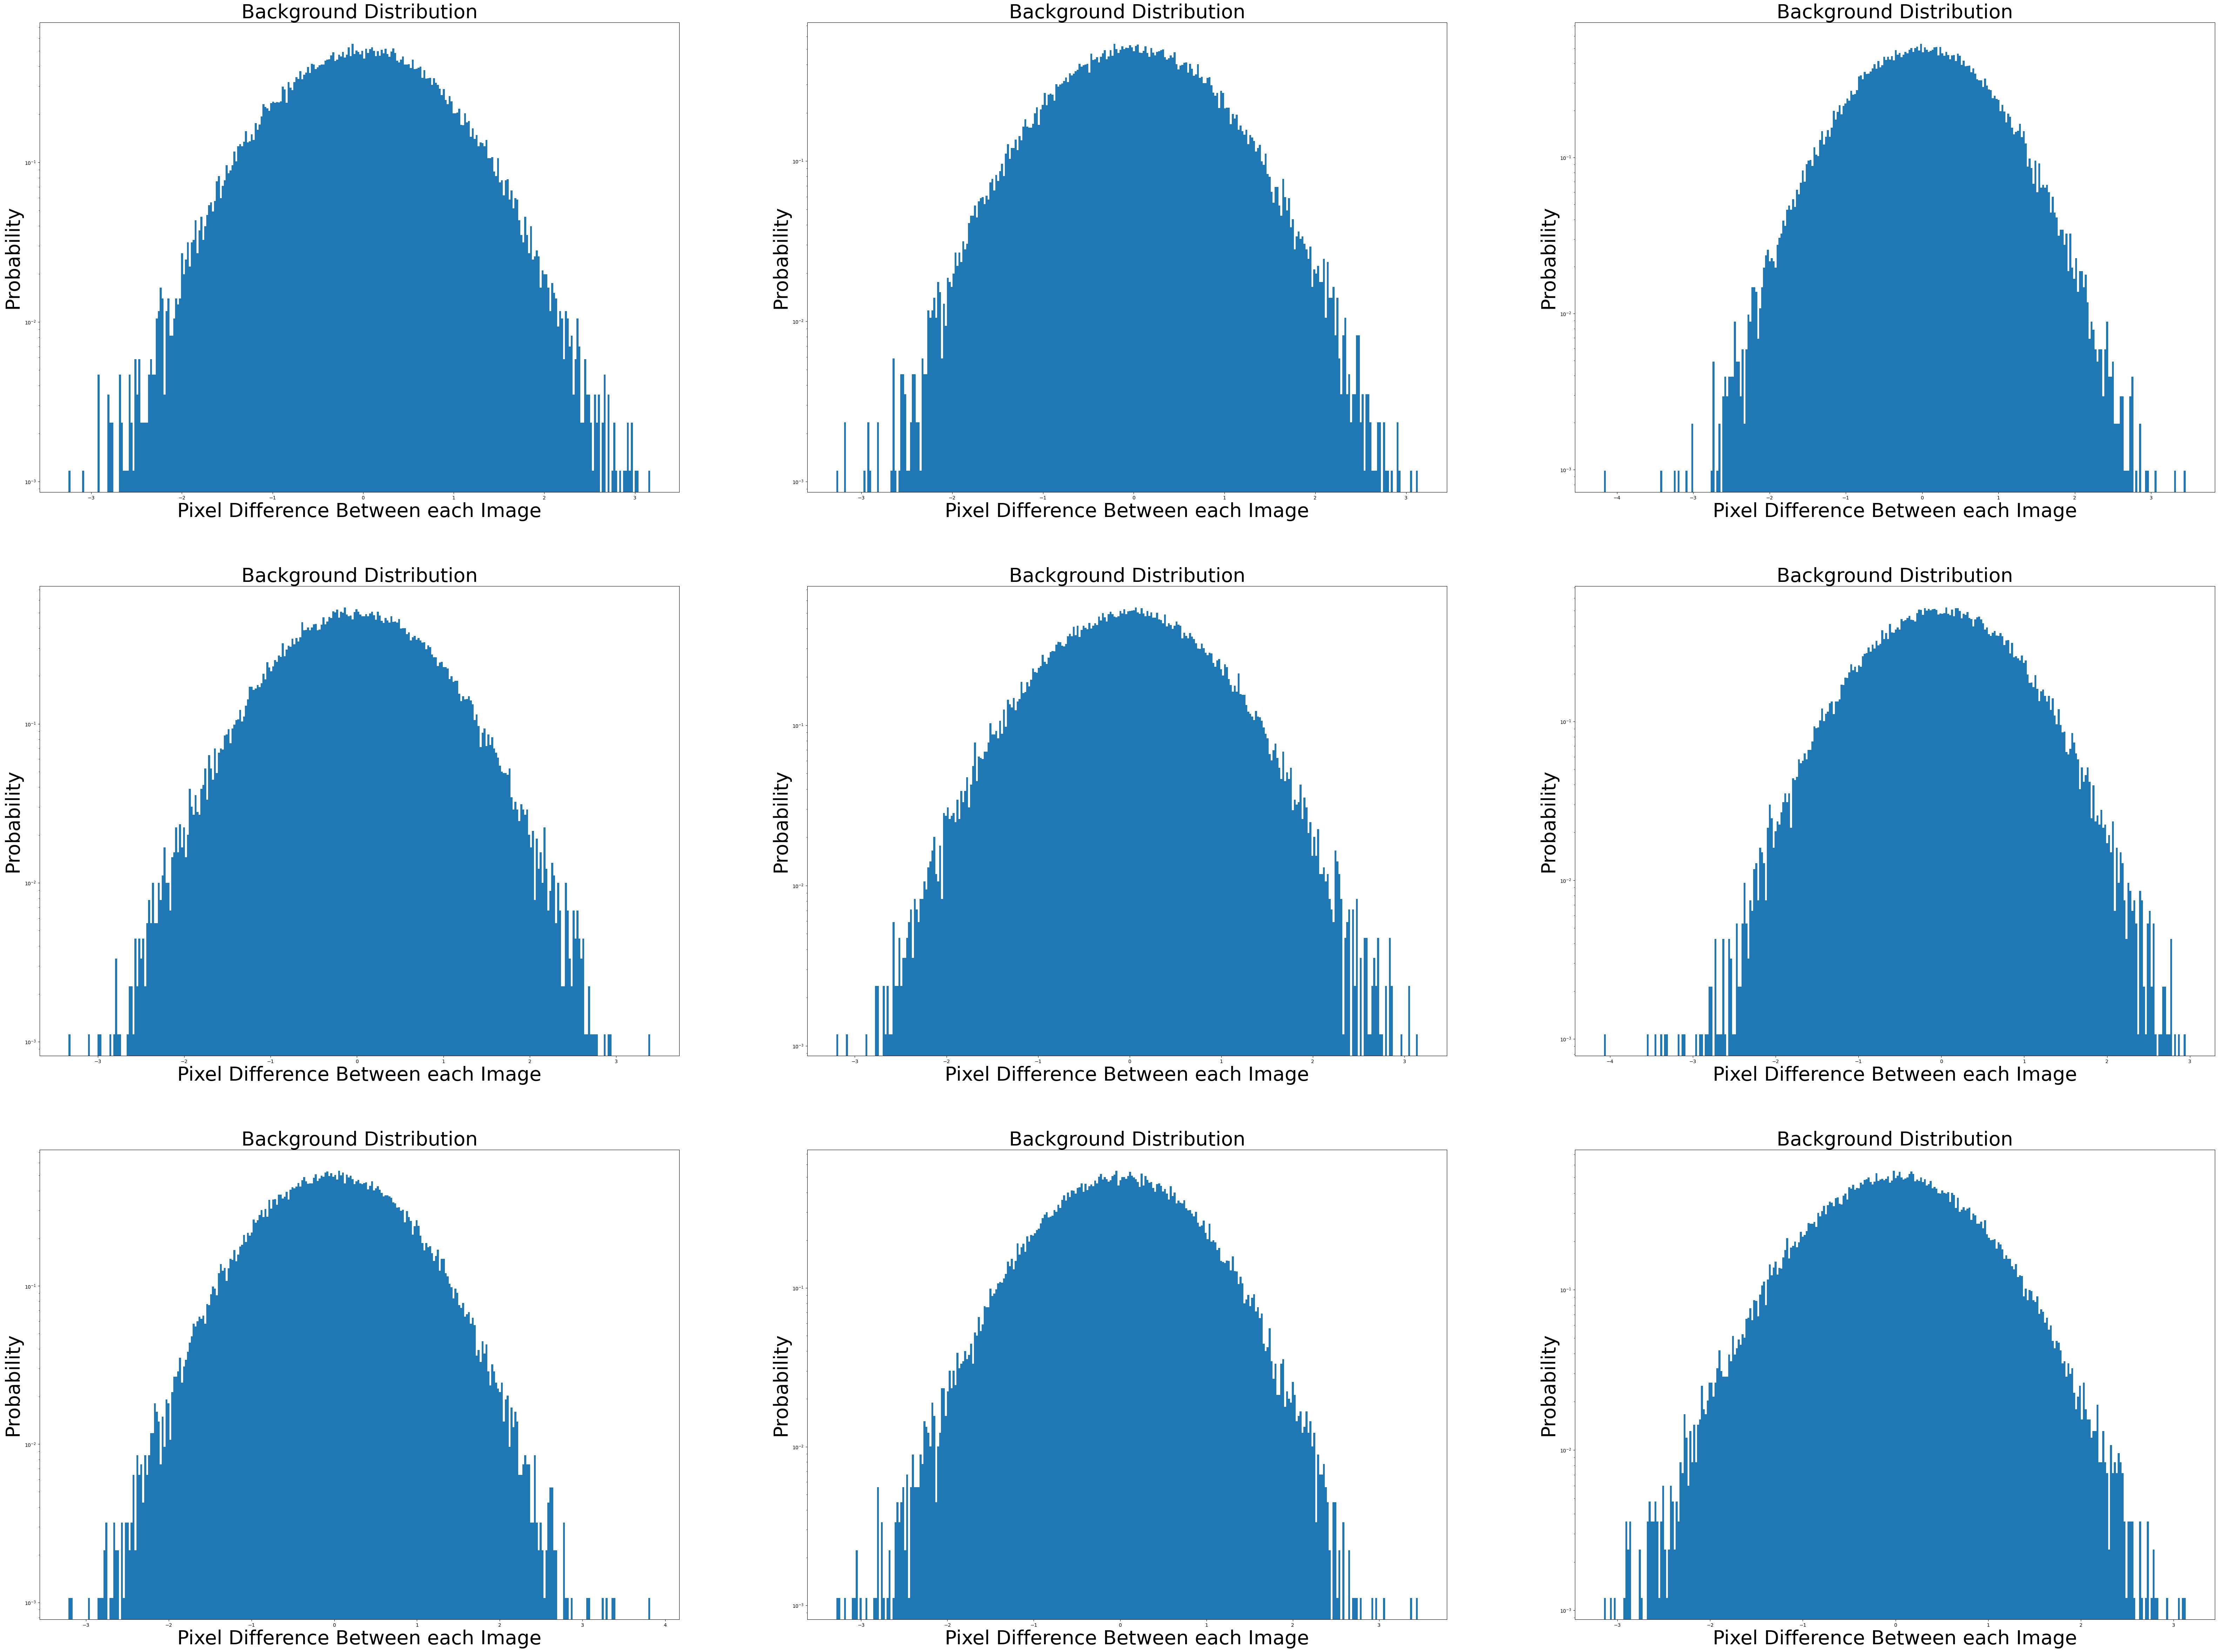

In [44]:
differences = []
mean = []
width = []
for i in range(9):
    change = imagedata[:,:,i+1] - imagedata[:,:,i]
    
    differences.append(change)
    mean.append(np.mean(change))
    width.append(np.std(change))
#len(differences)
differences = np.asarray(differences)

fig,ax = plt.subplots(4,3,figsize=(80,80))
plot = 0
for i in range(3):
    for j in range (3):
        ax[i,j].hist(differences[plot].ravel(),density = True, bins = 300)
        ax[i,j].set_title('Background Distribution',fontsize=40)
        ax[i,j].set_xlabel('Pixel Difference Between each Image',fontsize=40)
        ax[i,j].set_ylabel('Probability',fontsize=40)
        ax[i,j].semilogy()
        plot = plot + 1
fig.delaxes(ax[3][0])
fig.delaxes(ax[3][1])
fig.delaxes(ax[3][2])



This represents the difference between each image pixel by pixel. I took the semilog of the y-axis so that we can see the familiar normal distribution. This tells us that the background distribution does change with each image and as a result with time. Let us now use the background to find the transient.

In [40]:
threshold = []
for i in range(9):
    cdf = norm.cdf(5)
    ppf = norm(loc = mean[i],scale = width[i]).ppf(cdf)
    
    threshold.append(ppf)
threshold = np.asarray(threshold)

We need to find the 5-sigma detection, which in this case, is a difference in one pixel between images

In [38]:
length = len(threshold)
for i in range(length):
    change = np.abs(differences[i])
    
    #compare each value 
    signal = change[change>(threshold[i])]
    print(signal)

[]
[]
[4.16809729]
[]
[]
[4.07032241]
[]
[]
[]


This checks if any of the 'next' images have pixels that are different than the 'current' image. Anywhere that shows a number is a transient event. So, as shown above, the 4th and 7th images have differences from the previous image.

Differences in analysis arise from the fact that we analyzed the background differently to find the anomalous event in the images.